We will train a model using the largest dataset which corresponds to the Frontal AP data. We will then use tranfer learning to ease training the other models. 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from Scripts.data_utils import grab_processed_data

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

%load_ext autoreload
%autoreload 2

Testing = False

In [2]:
inputs = []
outputs = []

if not Testing:
    for idx in range(5):
        file_name = 'train_frontal_ap_' + str(idx)
        labels, X_temp, y_temp = grab_processed_data(file_name + '.csv', file_name + '.pkl')
        inputs.append(X_temp)
        outputs.append(y_temp)

labels, X_val, y_val = grab_processed_data('valid_frontal_ap' + '.csv', 'valid_frontal_ap' + '.pkl')        

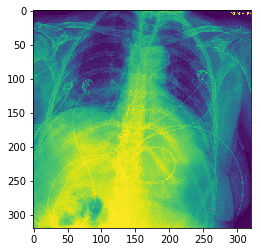

In [3]:
from random import randint

if not Testing:
    idx = randint(0, len(inputs[0]) -1)
    img = inputs[0][idx]
    img = np.reshape(img, (320, 320))
    plt.imshow(img)

In [4]:
train_data = []
val_data = []
test_data = []
mean = np.zeros((1,320,320))

if Testing:
    temp_train = []
    for idx in range(len(X_val)):
        temp_train.append([X_val[idx], y_val[idx]])
    train_data.append(temp_train)

    mean +=  np.mean(X_val)
    print('Testing :)')

else:
    for num, lat_set in enumerate(inputs):    
        shuffled_idxs = list(range(len(lat_set)))
        np.random.shuffle(shuffled_idxs)
    
        train_cutoff = int(lat_set.shape[0]*75/100)
        val_cutoff = int(lat_set.shape[0]*95/100)

        temp_train = []
        temp_val = []
        temp_test = []
    
        for i, idx in enumerate(shuffled_idxs):
            if i < train_cutoff:
                temp_train.append([lat_set[idx], outputs[num][idx]])
            elif i < val_cutoff:
                temp_val.append([lat_set[idx], outputs[num][idx]])
            else:
                temp_test.append([lat_set[idx], outputs[num][idx]])
        
        mean += np.mean(inputs[num][shuffled_idxs[:train_cutoff]])
        
        train_data.append(temp_train)
        val_data.append(temp_val)
        test_data.append(temp_test)
    
    temp_test = []
    for i in range(len(X_val)):
        temp_test.append([X_val[i], y_val[i]])
    test_data.append(temp_test)

    mean /= 5
    count = 0
    
    for idx in range(len(inputs)):
        count += inputs[idx].shape[0]
    
    print('Total training examples = ', count)
    print('Total validation examples = ', len(y_val))

Total training examples =  161590
Total validation examples =  169


In [41]:
train_loader = []
val_loader = []
test_loader = []

if Testing:
    train_loader.append(torch.utils.data.DataLoader(train_data[0], shuffle=True, batch_size=16))
else:
    for i in range(5):
        train_loader.append(torch.utils.data.DataLoader(train_data[i], shuffle=True, batch_size=32))
        val_loader.append(torch.utils.data.DataLoader(val_data[i], shuffle=True, batch_size=512))
        test_loader.append(torch.utils.data.DataLoader(test_data[i], shuffle=True, batch_size=512))
    test_loader.append(torch.utils.data.DataLoader(test_data[5], shuffle=True, batch_size=512))

In [42]:
only_val_test_data = []
temp_only_val = []
only_val_loader = []

for i in range(len(X_val)):
    temp_only_val.append([X_val[i], y_val[i]])
only_val_test_data.append(temp_only_val)

only_val_loader.append(torch.utils.data.DataLoader(only_val_test_data[0], shuffle=True, batch_size=16))


In [8]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 253
print(len(train_data[0])/32)

print('using device:', device)

757.4375
using device: cuda


In [10]:
import torchvision.models as models

model = None
optimizer = None 

learning_rate = 5e-4

mean_t = torch.tensor(mean).to(device=device, dtype=torch.float)

model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(1024, 5)
model.features[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

#model = models.alexnet(pretrained=True)
#model.classifier[6] = nn.Linear(4096,5)
#model.features[0] = nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2)

if USE_GPU and torch.cuda.is_available():
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=1e-5)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)

In [11]:
#Resetting Arrays for multiple tests
loss_arr = []

Acc_Train = []
TP_Rate_Train = []
FP_Rate_Train = []
Precision_Train = []
Prevalence_Train = []

Acc_Val = []
TP_Rate_Val = []
FP_Rate_Val = []
Precision_Val = []
Prevalence_Val = []

In [12]:
def check_accuracy(loader, model):

    TP = torch.zeros(5, dtype=dtype).to(device=device, dtype=dtype)
    FP = torch.zeros(5, dtype=dtype).to(device=device, dtype=dtype)
    FN = torch.zeros(5, dtype=dtype).to(device=device, dtype=dtype)
    TN = torch.zeros(5, dtype=dtype).to(device=device, dtype=dtype)
    
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for part_loader in loader:
            for x, y in part_loader:
                x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
                y = y.to(device=device, dtype=dtype)
                x -= mean_t

                preds = (torch.sigmoid(model(x)) > 0.5).to(device=device, dtype=dtype)
            
                confusion_vector = (preds/y).to(device=device, dtype=dtype)
                
                TP = (torch.sum((confusion_vector == 1.0), dim=0).to(device=device, dtype=dtype).add(TP)).to(device=device, dtype=dtype)
                FN = (torch.sum((confusion_vector == 0.0), dim=0).to(device=device, dtype=dtype).add(FN)).to(device=device, dtype=dtype)
                FP = (torch.sum((confusion_vector == float('inf')).to(device=device, dtype=dtype), dim=0).add(FP)).to(device=device, dtype=dtype)
                TN = (torch.sum(torch.isnan(confusion_vector), dim=0).to(device=device, dtype=dtype).add(TN)).to(device=device, dtype=dtype)

        acc = ((TP+TN)/(TP+FP+FN+TN)).cpu().numpy()
        tp_rate = (TP/(TP+FN)).cpu().numpy()
        fp_rate = (FP/(FP+TN)).cpu().numpy()
        precision = (TP/(TP+FP)).cpu().numpy()
        prevalence = ((TP+FN)/(TP+FP+FN+TN)).cpu().numpy()
        
        return (acc, tp_rate, fp_rate, precision, prevalence)

In [43]:
acc, tp_rate, fp_rate, precision, prevalence = check_accuracy(only_val_loader, model)
print(acc)

[0.5857988  0.65680474 0.8106509  0.852071   0.79881656]


In [15]:
import torch.nn.functional as F
############ FOR REFERENCE ############
def train(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    print(epochs)
    for e in range(epochs):
        print('Epoch num: ', e)
        for part_loader in train_loader:

            for t, (x, y) in enumerate(part_loader):
                model.train()  # put model to training mode
                x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
                y = y.to(device=device, dtype=torch.float)
                x -= mean_t
                scores = model(x)
            
                loss_fn = torch.nn.BCEWithLogitsLoss()
                loss = loss_fn(scores, y)

                optimizer.zero_grad()

                loss.backward()

                optimizer.step()

                loss_arr.append(loss.item())
                
                if t % print_every == 0:
                    print('Iteration %d, loss = %.4f' % (t, loss.item()))
                    
            print('Iteration %d, loss = %.4f' % (759, loss.item()))
            
            val_acc, tp_rate, fp_rate, precision, prevalence = check_accuracy(val_loader, model)
            Acc_Val.append(val_acc)
            TP_Rate_Val.append(tp_rate)
            FP_Rate_Val.append(fp_rate)
            Precision_Val.append(precision)
            Prevalence_Val.append(prevalence)
             
            test_acc, tp_rate, fp_rate, precision, prevalence = check_accuracy(train_loader, model)
            Acc_Train.append(test_acc)
            TP_Rate_Train.append(tp_rate)
            FP_Rate_Train.append(fp_rate)
            Precision_Train.append(precision)
            Prevalence_Train.append(prevalence)

            print('Val Acc ; Test Acc : ', np.mean(val_acc), ' ; ', np.mean(test_acc))
            print()
            

In [16]:
train(model, optimizer, epochs = 10)
torch.save(model.state_dict(), 'model_10.pth')

#model = TheModelClass(*args, **kwargs)
#model.load_state_dict(torch.load(PATH))
#model.eval()

10
Epoch num:  0
Iteration 0, loss = 0.6662
Iteration 253, loss = 0.4588
Iteration 506, loss = 0.3660
Iteration 759, loss = 0.3131
Val Acc ; Test Acc :  0.8218564  ;  0.8207921

Iteration 0, loss = 0.4634
Iteration 253, loss = 0.3946
Iteration 506, loss = 0.3838
Iteration 759, loss = 0.4037
Val Acc ; Test Acc :  0.81818074  ;  0.81816655

Iteration 0, loss = 0.3705
Iteration 253, loss = 0.5187
Iteration 506, loss = 0.4054
Iteration 759, loss = 0.3008
Val Acc ; Test Acc :  0.82748145  ;  0.8275749

Iteration 0, loss = 0.3580
Iteration 253, loss = 0.4678
Iteration 506, loss = 0.4267
Iteration 759, loss = 0.3569
Val Acc ; Test Acc :  0.8257488  ;  0.8263982

Iteration 0, loss = 0.3920
Iteration 253, loss = 0.3122
Iteration 506, loss = 0.4216
Iteration 759, loss = 0.4753
Val Acc ; Test Acc :  0.8173081  ;  0.8187029

Epoch num:  1
Iteration 0, loss = 0.4177
Iteration 253, loss = 0.3806
Iteration 506, loss = 0.3772
Iteration 759, loss = 0.4629
Val Acc ; Test Acc :  0.832698  ;  0.8330456

I

In [45]:
model_10_arrs = []

model_10_arrs.append(loss_arr)

model_10_arrs.append(Acc_Train)
model_10_arrs.append(TP_Rate_Train)
model_10_arrs.append(FP_Rate_Train)
model_10_arrs.append(Precision_Train)
model_10_arrs.append(Prevalence_Train)

model_10_arrs.append(Acc_Val)
model_10_arrs.append(TP_Rate_Val)
model_10_arrs.append(FP_Rate_Val)
model_10_arrs.append(Precision_Val)
model_10_arrs.append(Prevalence_Val)

with open("model_10.pkl", "wb") as fp:
    pickle.dump(model_10_arrs, fp)

In [ ]:
train(model, optimizer, epochs = 5)

5
Epoch num:  0
Iteration 0, loss = 0.3419
Iteration 253, loss = 0.4163
Iteration 506, loss = 0.4341
Iteration 759, loss = 0.4074
Val Acc ; Test Acc :  0.83565587  ;  0.84497565

Iteration 0, loss = 0.3461
Iteration 253, loss = 0.3140
Iteration 506, loss = 0.3861
Iteration 759, loss = 0.3151
Val Acc ; Test Acc :  0.837958  ;  0.8474264

Iteration 0, loss = 0.3114
Iteration 253, loss = 0.3105
Iteration 506, loss = 0.3688
Iteration 759, loss = 0.5326


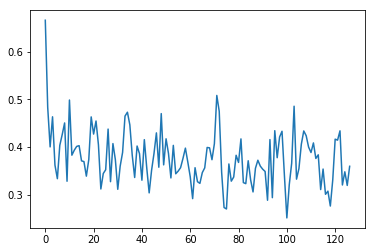

In [36]:
plt.plot(range(len(loss_arr[::300])), loss_arr[::300])

(50, 5)
(50, 5)


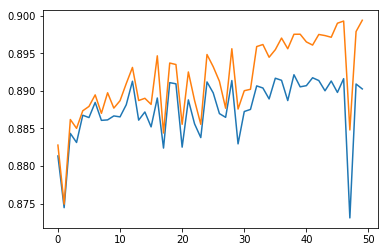

In [37]:
temp = np.asarray(Acc_Val)
print(temp.shape)
plt.plot(range(len(temp[:,1])), temp[:,1])

temp = np.asarray(Acc_Train)
print(temp.shape)
plt.plot(range(len(temp[:,1])), temp[:,1])

In [ ]:
clipped_loss = []
for element in loss_arr:
    if element > 5.0:
        clipped_loss.append(0.8)
    else:
        clipped_loss.append(element)

In [ ]:
plt.plot(range(len(clipped_loss)), clipped_loss)